### Import Libraries

In [24]:
import os
import numpy as np
import librosa
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

### 1. Pre-processing

In [25]:
sample_rate = 16000
frame_length = int(0.032 * sample_rate)  # 32ms
hop_length = frame_length//2    # 16ms

In [26]:
def select_cry_frames_using_energy(signal: np.ndarray, frame_length, hop_length, thresh=0.1) -> list:
    energy = np.array([
        sum(abs(signal[i:i+frame_length]**2))
        for i in range(0, len(signal), hop_length)
    ])
    energy_norm = energy / max(energy)
    index_cry = [i for i in range(len(energy)) if energy_norm[i] >= thresh]
    return index_cry

def split_segments(index_voices: list, hop_length, sr, duration_ms=30) -> list:
    """
    Chia các khung tiếng khóc thành các phân đoạn có độ dài chính xác theo ms (200ms).
    """
    # Tính số frame tương ứng với 200ms
    frames_per_segment = int(duration_ms * sr / 1000 / hop_length)
    
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            # Khi có một khoảng cách giữa các khung lớn hơn 1 frame, thêm phân đoạn trước đó
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    # Thêm phân đoạn cuối cùng
    segments.append((start, index_voices[-1]))

    # Chỉ giữ lại những phân đoạn có đúng số frame tương ứng với 200ms
    return [(start, end) for start, end in segments if (end - start) == frames_per_segment]

### 2. Features Extraction

In [27]:
n_mfcc = 40
n_fft = 1024  # setting the FFT size to 1024
hop_length = 10*16 # 25ms*16khz samples has been taken
win_length = 25*16 #25ms*16khz samples has been taken for window length
window = 'hann' #hann window used
n_chroma=12
n_mels=128
n_bands=7 #we are extracting the 7 features out of the spectral contrast
fmin=100
bins_per_ocatve=12

In [28]:
def extract_features(y, sr):    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40,n_fft=n_fft,hop_length=hop_length,win_length=win_length,window=window).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann',n_mels=n_mels).T,axis=0)
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, y=y, sr=sr).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, y=y, sr=sr,n_fft=n_fft,
                                                    hop_length=hop_length, win_length=win_length,
                                                    n_bands=n_bands, fmin=fmin).T,axis=0)
    tonnetz =np.mean(librosa.feature.tonnetz(y=y, sr=sr).T,axis=0)
    features = np.concatenate((mfcc, chroma, mel, contrast, tonnetz))
    # print(shape(features))
    return features

In [29]:
# def extract_features(signal, sr, n_mfcc=12, n_fft=512):
#     # Trích xuất MFCC (Mel Frequency Cepstral Coefficients)
#     mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    
#     # Trích xuất RMS (Root Mean Square)
#     rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)
    
#     # Trích xuất Zero-Crossing Rate (ZCR)
#     zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=frame_length, hop_length=hop_length)
    
#     spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)
#     spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)
#     spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)
#     spectral_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
#     mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=frame_length, n_mels=128)
    
#     # Trả về tất cả các đặc trưng: MFCCs, RMS, và Zero-Crossing Rate
#     # return np.concatenate([mfccs, rms, zcr], axis=0).reshape(-1)
#     features = np.concatenate([ mfccs, zcr, spectral_bandwidth, spectral_contrast, spectral_centroid, spectral_rolloff, mel_spectrogram], axis=0)
#     features = features.reshape(-1)
#     return features


In [30]:
data_dir = 'data_bbcry_classification'

for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    
    if os.path.isdir(class_dir):
        file_count = len(os.listdir(class_dir))  
        print(f"Lớp {label} có {file_count} file.")

Lớp belly_pain có 36 file.
Lớp burping có 27 file.
Lớp discomfort có 36 file.
Lớp scared có 30 file.
Lớp tired có 42 file.


In [31]:
X = []
y = []

# Duyệt qua từng lớp
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        
        # Load file âm thanh
        signal, sr = librosa.load(file_path, sr=16000)
       
        features = extract_features(signal, sr)
        X.append(features)
        y.append(label)

In [32]:
# X = []
# y = []

# # Duyệt qua từng lớp
# for label in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, label)
#     if not os.path.isdir(class_dir):
#         continue
#     for file_name in os.listdir(class_dir):
#         file_path = os.path.join(class_dir, file_name)
        
#         # Load file âm thanh
#         signal, sr = librosa.load(file_path, sr=16000)
        
#         # Chọn các frame chứa tiếng khóc dựa vào năng lượng chuẩn hóa
#         index_cry = select_cry_frames_using_energy(signal, frame_length, hop_length)
        
#         # Chia các frame thành các segment
#         segments = split_segments(index_cry, hop_length, sr)
        
#         # Trích xuất đặc trưng cho từng segment
#         for (start, end) in segments:
#             segment = signal[start * hop_length : end * hop_length]
#             features = extract_features(segment, sr)
#             X.append(features)
#             y.append(label)

In [33]:
print("Kích thước của X:", np.shape(X))
print("Kích thước của y:", np.shape(y))

Kích thước của X: (171, 194)
Kích thước của y: (171,)


### 3. Train Test Split

In [34]:
# Chuyển đổi nhãn sang dạng số
le = LabelEncoder()
y = le.fit_transform(y)

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
print("Kích thước của X_train:", np.shape(X_train))
print("Kích thước của X_test:", np.shape(X_test))
print("Kích thước của y_train:", np.shape(y_train))
print("Kích thước của y_test:", np.shape(y_test))

Kích thước của X_train: (119, 194)
Kích thước của X_test: (52, 194)
Kích thước của y_train: (119,)
Kích thước của y_test: (52,)


### 4. Training Model

Model: Random Forest, Accuracy: 0.846154, F1 score: 0.849626
Model: Bagged Tree, Accuracy: 0.865385, F1 score: 0.870894
Model: KNN, Accuracy: 0.480769, F1 score: 0.471195
       Algorithm  Accuracy Score  F1 Score
0  Random Forest        0.846154  0.849626
1    Bagged Tree        0.865385  0.870894
2            KNN        0.480769  0.471195


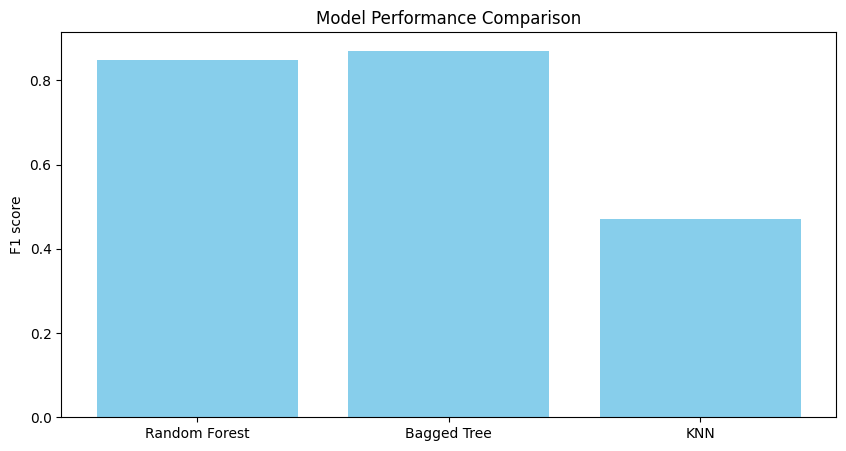

In [36]:
# Huấn luyện và đánh giá mô hình
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Bagged Tree': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100),
    'KNN':  KNeighborsClassifier(n_neighbors=4),
    # 'SVM': SVC(kernel='linear', C=1, random_state=42),
}

results = []
# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=2, scoring='f1_weighted')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.6f}, F1 score: {f1:.6f}")
    results.append({'Algorithm': model_name, 'Accuracy Score': accuracy, 'F1 Score': f1})


results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(10, 5))
plt.bar(results_df['Algorithm'], results_df['F1 Score'], color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('F1 score')
plt.show()

#### Confusion matrix

Shape of confusion matrix: (5, 5)
Number of classes: 5


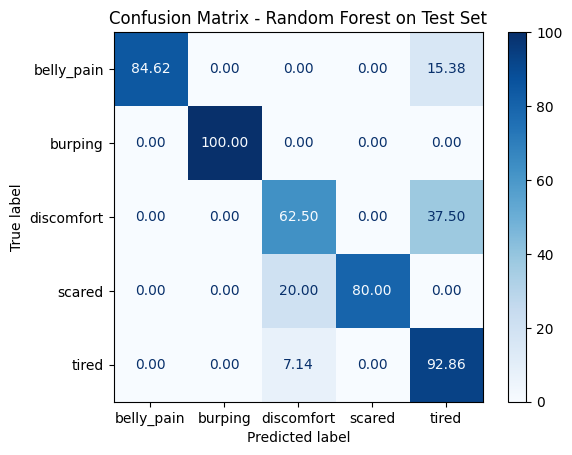

In [37]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Kiểm tra kích thước của ma trận confusion matrix
print("Shape of confusion matrix:", cm.shape)

# Kiểm tra số lớp trong ma trận và cập nhật lại display_labels nếu cần
num_classes = cm.shape[0]
print("Number of classes:", num_classes)

# Điều chỉnh display_labels sao cho phù hợp với số lớp
display_labels = ['belly_pain', 'burping', 'discomfort', 'scared', 'tired'][:num_classes]

# Hiển thị confusion matrix với đúng số lượng lớp
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=display_labels)
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Random Forest on Test Set")
plt.show()


In [41]:
def extract_features_from_testing_directory(testing_dir):
    X_test_files = []
    segment_file_info = []  # Lưu thông tin về các segment và tên tệp tương ứng

    for file_name in os.listdir(testing_dir):
        file_path = os.path.join(testing_dir, file_name)
        
        if not os.path.isfile(file_path):
            continue
        
        signal, sr = librosa.load(file_path, sr=16000)

        features = extract_features(signal, sr)
            
        if features is not None:
            X_test_files.append(features)
            segment_file_info.append(file_name)  # Lưu tên tệp âm thanh tương ứng cho segment
        else:
            print(f"Warning: No MFCC extracted for segment in {file_path}")
    
    if len(X_test_files) > 0:
        return np.array(X_test_files), segment_file_info
    else:
        return np.array([]), []


def predict_testing_files(model_name, testing_dir, label_encoder):
    X_test_files, segment_file_info = extract_features_from_testing_directory(testing_dir)
    
    if X_test_files.size == 0:
        print("No valid files found in testing directory or MFCC extraction failed.")
        return

    # Dự đoán cho từng segment
    y_pred = model_name.predict(X_test_files)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    # In kết quả dự đoán cho từng segment
    for i, predicted_class in enumerate(y_pred_labels):
        file_name = segment_file_info[i]  # Tên tệp âm thanh tương ứng
        print(f"File: {file_name} - Predicted Class for Segment {i+1}: {predicted_class}")


# Sử dụng
label_encoder = LabelEncoder()
label_encoder.fit(['belly_pain', 'burping', 'discomfort', 'scared', 'tired'])

testing_dir = 'testing_function2/dc'  # Đảm bảo thư mục này chứa các tệp cần dự đoán
predict_testing_files(rf_model, testing_dir, label_encoder)


File: 64acb345-a61e-4ef3-a5a6-cf83c04b83f1-1430058990597-1.7-m-72-dc.wav - Predicted Class for Segment 1: discomfort
File: 64acb345-a61e-4ef3-a5a6-cf83c04b83f1-1430059012473-1.7-m-72-dc.wav - Predicted Class for Segment 2: burping
File: 7b0e160e-0505-459e-8ecb-304d7afae9d2-1437486974312-1.7-m-04-dc.wav - Predicted Class for Segment 3: discomfort
File: 837fd072-8704-4196-9ff1-1d2c07886e55-1432429478471-1.7-m-22-dc.wav - Predicted Class for Segment 4: tired
File: a40b9b8d-e4bc-457a-badf-f38bdbc0c358-1430016981469-1.7-m-26-dc.wav - Predicted Class for Segment 5: burping
File: a40b9b8d-e4bc-457a-badf-f38bdbc0c358-1430017040912-1.7-m-26-dc.wav - Predicted Class for Segment 6: discomfort
File: ae5a462b-5424-4b5b-82d5-07ccb61654ab-1431064345173-1.7-f-48-dc.wav - Predicted Class for Segment 7: discomfort
File: d6cda191-4962-4308-9a36-46d5648a95ed-1426942891562-1.4-f-48-dc.wav - Predicted Class for Segment 8: tired
File: d6cda191-4962-4308-9a36-46d5648a95ed-1431161889263-1.7-m-04-dc.wav - Predi

In [39]:
import joblib

model_filename = 'randomforest_model_classification.pkl'

# Lưu mô hình
joblib.dump(rf_model, model_filename)

print(f"Mô hình đã được lưu thành công tại {model_filename}")

Mô hình đã được lưu thành công tại randomforest_model_classification.pkl
